In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
from PIL import Image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
image_path = []
labels = [] 

for i in os.listdir("/kaggle/input/animal-faces/afhq"):
    for label in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}"):
        for image in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}/{label}"):
            image_path.append(f"/kaggle/input/animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)


data_df = pd.DataFrame(zip(image_path, labels), columns=['image_path', 'labels'])


In [4]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]
        
    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx,0]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)

        return image, label


        

In [7]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

In [8]:
lr_rate = 1e-4
batch_size = 32
epochs = 10

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
for x, y in train_dataloader:
    print(y)
    break

tensor([2, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 2,
        2, 0, 0, 1, 0, 2, 1, 0], device='cuda:0')


In [11]:
class net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)# nn.Conv2d(inputchannel, outputchannel)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2,2)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.linear = nn.Linear((128*16*16), 128)
        self.output = nn.Linear(128, len(data_df['labels'].unique()))

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.flatten(x)

        x = self.linear(x)
        x = self.output(x)

        return x

In [12]:
model = net().to(device)

In [13]:
from torchsummary import summary
summary(model, input_size =(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr_rate)

In [15]:
total_loss_train_plot = []
total_acc_train_plot = []
total_loss_val_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
    total_loss_train = 0
    total_acc_train = 0 
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        output = model(inputs)

        train_loss = criterion(output, labels)
        train_loss.backward()
        
        total_loss_train += train_loss.item()
        

        acc = (torch.argmax(output, axis=1) == labels).sum().item()
        total_acc_train += acc

        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            output = model(inputs)

            val_loss = criterion(output, labels)

            
            total_loss_val += val_loss.item()
            
    
            acc = (torch.argmax(output, axis=1) == labels).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_val_plot.append(round(total_loss_val/1000,4))

    total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) *100,4))
    total_acc_val_plot.append(round((total_acc_val/val_dataset.__len__()) *100,4))

    print(f"epoch:{epoch}, train_Loss:{round(total_loss_train/1000,4)}, train_acc:{round((total_acc_train/train_dataset.__len__()) *100,4)}")
    print(f"epoch:{epoch}, val_Loss:{round(total_loss_val/1000,4)}, val_acc:{round((total_acc_val/val_dataset.__len__()) *100,4)}")



    

epoch:0, train_Loss:0.1964, train_acc:76.4237
epoch:0, val_Loss:0.0235, val_acc:88.6777
epoch:1, train_Loss:0.085, train_acc:91.1611
epoch:1, val_Loss:0.0159, val_acc:92.3967
epoch:2, train_Loss:0.0609, train_acc:93.6144
epoch:2, val_Loss:0.0134, val_acc:93.843
epoch:3, train_Loss:0.0446, train_acc:95.3768
epoch:3, val_Loss:0.0116, val_acc:93.843
epoch:4, train_Loss:0.0332, train_acc:96.6168
epoch:4, val_Loss:0.0106, val_acc:94.876
epoch:5, train_Loss:0.0254, train_acc:97.5201
epoch:5, val_Loss:0.0106, val_acc:95.5372
epoch:6, train_Loss:0.0214, train_acc:97.7681
epoch:6, val_Loss:0.0106, val_acc:95.4959
epoch:7, train_Loss:0.017, train_acc:98.3438
epoch:7, val_Loss:0.012, val_acc:94.8347
epoch:8, train_Loss:0.0141, train_acc:98.7601
epoch:8, val_Loss:0.0101, val_acc:95.4959
epoch:9, train_Loss:0.0097, train_acc:99.0258
epoch:9, val_Loss:0.0105, val_acc:95.8264


In [18]:
with torch.no_grad():
    total_loss_test= 0
    total_acc_test = 0
    for inputs, labels in test_dataloader:
            output = model(inputs)

            test_loss = criterion(output, labels)

            
            total_loss_test += test_loss.item()
            
    
            acc = (torch.argmax(output, axis=1) == labels).sum().item()
            total_acc_test += acc
print(f"test_Loss:{round(total_loss_test/1000,4)}, test_acc:{round((total_acc_test/test_dataset.__len__()) *100,4)}")



test_Loss:0.0089, test_acc:96.4035


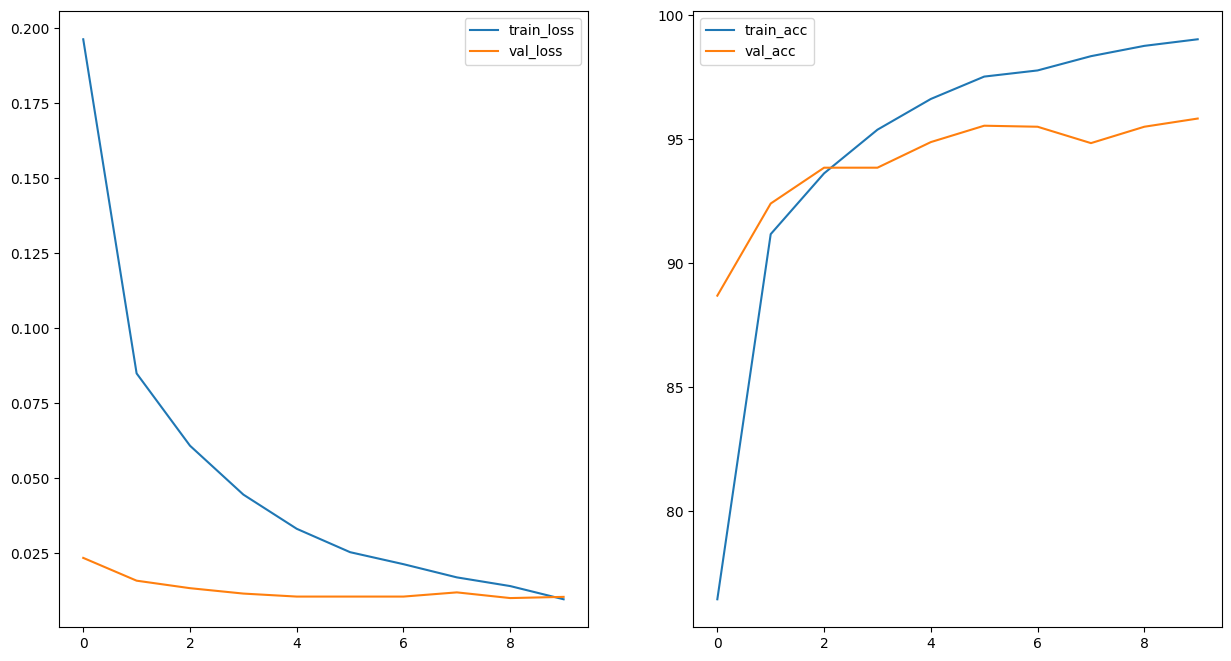

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
axs[0].plot(total_loss_train_plot, label='train_loss')
axs[0].plot(total_loss_val_plot, label='val_loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='train_acc')
axs[1].plot(total_acc_val_plot, label='val_acc')
axs[1].legend()

In [50]:
def predict_img(image_path):
    image = Image.open(image_path).convert('RGB') 
    image = transform(image).to(device)
    pred = model(image.unsqueeze(0))
    output = torch.argmax(pred,axis=1).item()
    return label_encoder.inverse_transform([output])

In [51]:
pred = predict_img("/kaggle/input/animal-face-cat-test/image_class_test.jpg")
pred

array(['cat'], dtype=object)